# SUP ML 2 - MODEL

# Libraries

In [193]:
# Datos
import pandas as pd
import numpy as np
import pickle

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Métricas Clasificación
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
from scipy.stats import uniform, randint

# Modelos a Entrenar
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# inhabilita warnings
import warnings
warnings.filterwarnings("ignore")

# Carga clean data

In [194]:
df = pd.read_csv('C:/Users/aalei/Desktop/Marzo 2024/ENTREGA2_COPY/model/df_clean.csv')

In [195]:
# Columna Customer_ID transformada a índice
df=df.set_index('Customer_ID')
print('Updated index to Customer_ID')
print('Rows: ', df.shape[0], '  Columns: ', df.shape[1], '\n')
df.head(2)

Updated index to Customer_ID
Rows:  90000   Columns:  125 



,rev,mou,totmrc,change_mou,drop_vce,drop_dat,blck_vce,blck_dat,unan_vce,unan_dat,...,ethnic_H,ethnic_I,ethnic_J,ethnic_N,ethnic_O,ethnic_OTHER,ethnic_S,ethnic_U,ethnic_Z,creditcd_N
Customer_ID,,,,,,,,,,,,,,,,,,,,,
1000001,23.9975,219.25,22.500,-157.25,0.666667,0.0,0.666667,0.0,6.333333,0.0,...,False,False,False,True,False,False,False,False,False,False
1000002,57.4925,482.75,37.425,532.25,8.333333,0.0,1.000000,0.0,61.333333,0.0,...,False,False,False,False,False,False,False,False,True,False


# Split X-y

In [196]:
target = 'churn'
features = df.columns[df.columns!=target]
X = df[features]
y = df[target]
print('Rows X: ', X.shape[0], '  Columns X: ', X.shape[1], '   y: Churn')

Rows X:  90000   Columns X:  124    y: Churn


# Distribución del target

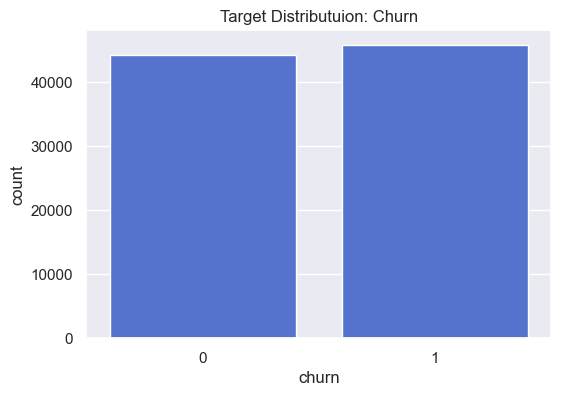

In [197]:
sns.set()
plt.figure(figsize=[6,4])
sns.countplot(x=y,color='#4169E1')
plt.title('Target Distributuion: Churn')
plt.show()

In [198]:
dif = (df['churn'].value_counts()[0]*100/len(df)) - (df['churn'].value_counts()[1]*100/len(df))
print(f'Diference between target values: {round(dif, 2)}')

Diference between target values: -1.78


# Split TRAIN-TEST

In [199]:
# RANDOM HOLDOUT
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30,stratify=y,random_state= 7)
print(f'Data divided: 30% for test')
print('Train data instances:', len(y_train))
print('Test data instances:', len(y_test))

Data divided: 30% for test
Train data instances: 63000
Test data instances: 27000


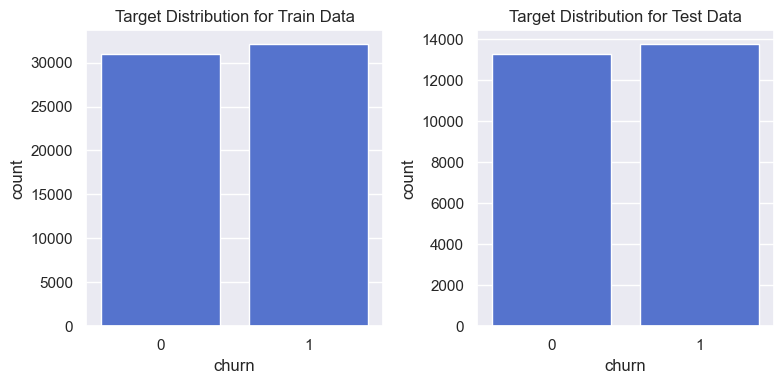

In [200]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
# Gráfico para y_train
sns.countplot(x=y_train, ax=axes[0], color='#4169E1')
axes[0].set_title('Target Distribution for Train Data')

# Gráfico para y_test
sns.countplot(x=y_test, ax=axes[1], color='#4169E1')
axes[1].set_title('Target Distribution for Test Data')

plt.tight_layout()
plt.show()

In [201]:
# Distribucion en %
print(f'% Target distribution for TRAIN DATA: {(y_train.value_counts() / len(y_train)*100).round()}')
print(f'% Target distribution for TEST DATA: {(y_test.value_counts() / len(y_test)*100).round()}')

% Target distribution for TRAIN DATA: churn
1    51.0
0    49.0
Name: count, dtype: float64
% Target distribution for TEST DATA: churn
1    51.0
0    49.0
Name: count, dtype: float64


# TRAIN-VALIDA

## Torneo de Modelos

* Probamos 2 modelos con el objetivo de conseguir el mejor rendimiento del modelo en los datos de VALIDACION.

In [202]:
# Funcion que calcula el AUC de un modelo sobre un dataset (X-y)
def auc(model,X,y):
  model.fit(X,y)
  return roc_auc_score(y,model.predict_proba(X)[:,1])

# Funcion que calcula el AUC en Cross-Validation (X-y)
def auc_cross_validation(model,X,y):
  cross_val = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
  return cross_val.mean()

In [203]:
label_, auc_train_ , auc_valida_ = [], [], []
def evaluate_classification(model, X, y, label=None):
  if label is None:
    label=str(model)
  label_.append(label)

  auc_train = auc(model,X,y)
  auc_valida = auc_cross_validation(model,X,y)
  auc_train_.append(auc_train)
  auc_valida_.append(auc_valida)

  return pd.DataFrame({'Model': label_,
                      'AUC Train': auc_train_,
                      'AUC Cross-Valida': auc_valida_
                      }).sort_values('AUC Cross-Valida',ascending=False)

In [204]:
# CatBoostClassifier
CatBoostClassifier = CatBoostClassifier(verbose=False)
evaluate_classification(model = CatBoostClassifier,X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
0,<catboost.core.CatBoostClassifier object at 0x0000021848EC8E90>,0.810939,0.685868


In [205]:
# XGBClassifier
evaluate_classification(model = XGBClassifier(),X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
0,<catboost.core.CatBoostClassifier object at 0x0000021848EC8E90>,0.810939,0.685868
1,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)",0.857295,0.666877


# TEST

* Evaluación de las métricas de performance en TEST.

In [206]:
# Predicciones del modelo en los datos de TEST (validación)
y_test_pred = CatBoostClassifier.predict(X_test)

# Probabilidad de que sea un caso positivo (éxito) para cada una de las observaciones
y_test_pred_proba = CatBoostClassifier.predict_proba(X_test)[:, 1]  

In [207]:
# Predicciones del modelo en los datos de TRAIN
y_train_pred = CatBoostClassifier.predict(X_train)    

# Probabilidad de que sea un caso positivo (éxito) para cada una de las observaciones
y_train_pred_proba = CatBoostClassifier.predict_proba(X_train)[:, 1]

In [208]:
# AUC
auc_train = roc_auc_score(y_train, y_train_pred_proba)  
auc_test = roc_auc_score(y_test, y_test_pred_proba)  
print('AUC Train:', round(auc_train,4))
print('AUC Test:', round(auc_test,4))

AUC Train: 0.8109
AUC Test: 0.6865


In [209]:
# ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

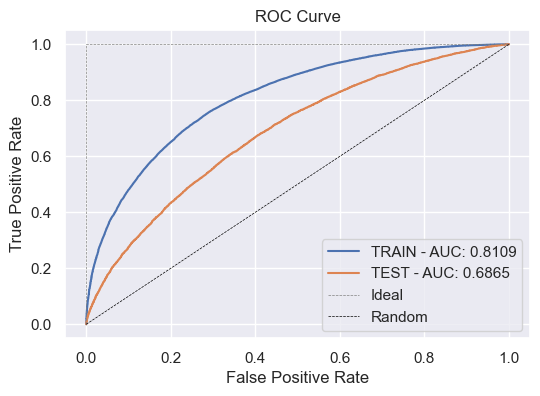

In [210]:
# ROC Curve
plt.figure(figsize=[6,4])
plt.plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
plt.title('ROC Curve')
plt.plot([0,0,1],[0,1,1], color='grey', linestyle='--', linewidth=0.5, label='Ideal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[]

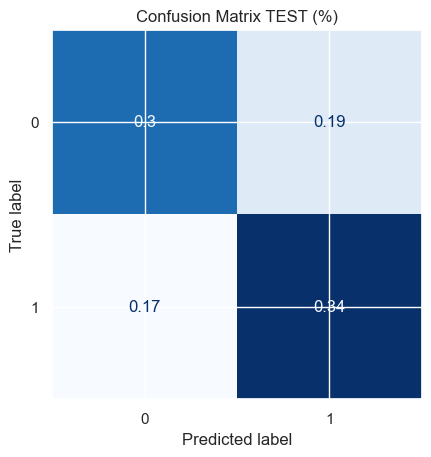

In [211]:
# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_test/len(y_test)).plot(colorbar = False, cmap = 'Blues')
plt.title('Confusion Matrix TEST (%)')
plt.plot()

In [212]:
accuracy = round( accuracy_score(y_test, y_test_pred),4)
precision = round( precision_score(y_test, y_test_pred), 4)
recall = round( recall_score(y_test, y_test_pred), 4)
f1_value = round(f1_score(y_test, y_test_pred), 4)

metrics_df = pd.DataFrame({
    'Metrica': ['accuracy', 'precision', 'recall', 'f1_score'],
    'Valor': [accuracy, precision, recall, f1_value]
})
metrics_df

,Metrica,Valor
0,accuracy,0.6343
1,precision,0.6353
2,recall,0.6606
3,f1_score,0.6477


# INTERPRETABILITY

In [213]:
dic = pd.read_csv('C:/Users/aalei/Desktop/Marzo 2024/ENTREGA2_COPY/data/variable_dictionary.csv')
var_shap = ['months','eqpdays','change_mou','mou','totmrc','drop_vce','avgqty','hnd_price','lor','avg_rev','avgmou','uniqsubs','avg3mou','mou_cvce','crclscod_E','iwylis_vce','asl_flag','avg3rev','mou_opkv','drop_blk']
pd.set_option('display.max_colwidth', None)
dic[dic['Variable'].isin(var_shap)]

,Variable,Description
1,mou,Mean number of monthly minutes of use
2,totmrc,Mean total monthly recurring charge
9,change_mou,Percentage change in monthly minutes of use vs previous three month average
11,drop_vce,Mean number of dropped (failed) voice calls
28,mou_cvce,Mean unrounded minutes of use of completed voice calls
33,iwylis_vce,Mean number of inbound wireless to wireless voice calls
41,mou_opkv,Mean unrounded minutes of use of off-peak voice calls
43,drop_blk,Mean number of dropped or blocked calls
49,months,Total number of months in service
50,uniqsubs,Number of unique subscribers in the household


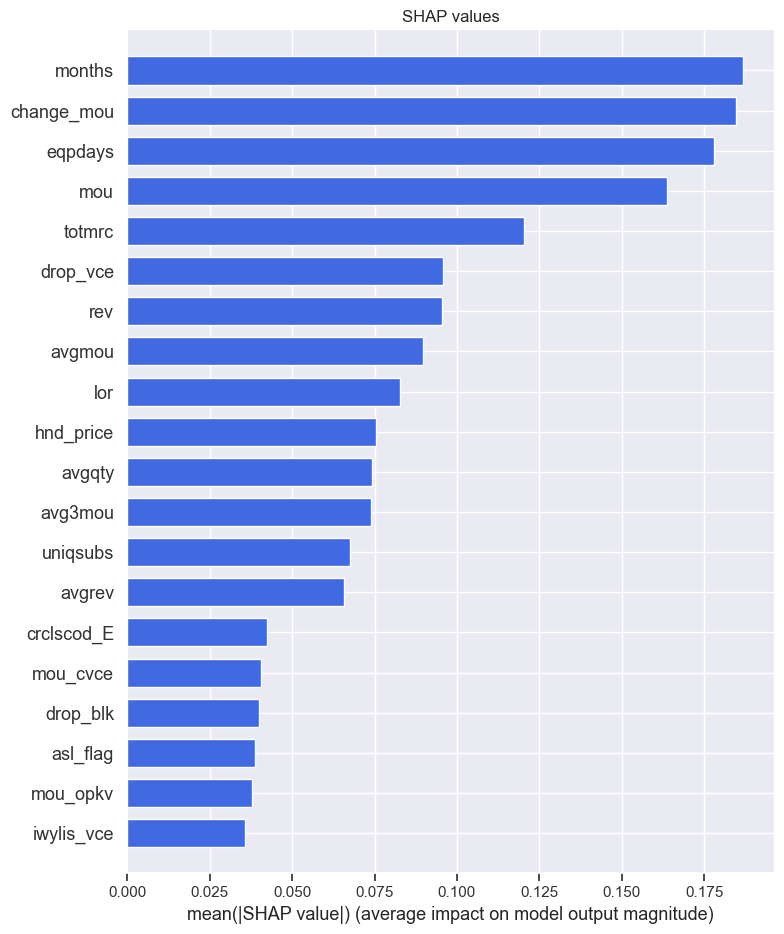

In [214]:
# SHAP value
explainer = shap.TreeExplainer(CatBoostClassifier)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20,color='#4169E1')

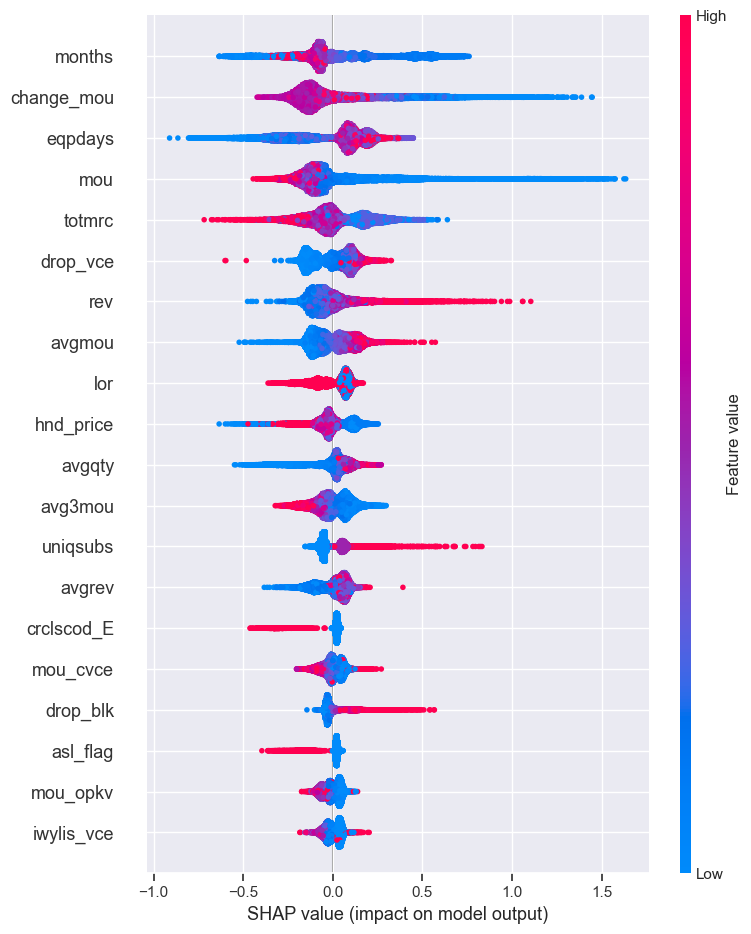

In [215]:
shap.summary_plot(shap_values, X_test)

## Guardar modelo

In [216]:
pickle.dump(CatBoostClassifier, open('C:/Users/aalei/Desktop/Marzo 2024/ENTREGA2_COPY/model/here_you_save_model_and_preprocessors.txt', 'wb'))